# Steel temperature prediction - industry

In order to optimize production costs, a steel plant (ironworks) decided to reduce electricity consumption at the stage of steel processing.

### Contents

<a href='#zero'> 0) Explanations and clarifying questions</a> <br/>
<a href='#first'>1) Data preprocessing and EDA</a> <br/>
<a href='#second'>2) Feature engineering</a> <br/>
<a href='#third'>3) Machine learning</a> <br/>
<a href='#fourth'>4) Test </a> <br/>
<a href='#fifth'>5) Summary</a>

<a id='zero'></a>
### Technological process

Steel is processed in a metal ladle. Molten steel is poured into a ladle and heated to the desired temperature with graphite electrodes. They are installed in the lid of the bucket. Sulfur is removed from the alloy, the chemical composition is corrected by adding impurities, and samples are taken. Steel is alloyed - its composition is changed - by feeding pieces of alloy from a bunker for bulk materials or wire.

Before introducing alloying additives for the first time, the temperature of the steel is measured and its chemical analysis is carried out. Then the temperature is raised for several minutes, alloying materials are added and the alloy is purged with an inert gas. Then it is stirred and measured again. This cycle is repeated until the target chemical composition and optimum melting temperature are reached.

### Work plan

1) **Refining the task and metrics for the model evaluation**. Ask clarifying questions listed below and determine the final goal of the project, find out the quality assessment metric and its target, and clarify the technological process.

2) **Feature extraction for learning**. At this stage, the available data will be re-analyzed. In addition to analysis and preprocessing, if necessary, features will be selected for learning the model.

3) **Machine learning**. Iterating through different models to select the one that will show the best value of the metric on the validation data.

4) **Model testing**. Model validation on test data.

5) **Summarizing the results and presenting them to the customer**. Writing a report on the work done, formulating conclusions. Presentation of conclusions in a form convenient to the customer.

### List of clarifying questions
1) The goal of the project is to **reduce electricity consumption**. Are we sure the target is temperature? Can consumption be reduced by optimizing other steps? If so, can we lose quality of steel and by how much? <br>
2) At what specific stage do you need **a temperature forecast**: at each iteration of batch processing / average batch temperature / maximum temperature / other?<br>
3) At what point does the temperature measurement take place? Does the machine determine this automatically or is it determined by a specialist? <br>
4) How will the quality of the constructed model be assessed: metrics / other qualitative information?<br>
5) What value of the metric should be achieved?<br>
6) In what format is the customer expected to present the findings/report on the model?<br>
7) Will the test data be presented separately?<br>
8) What could be the reason for a very low temperature, for example, there is a small number (about 0.1% of all measurements), around 1200 degrees, with an average of 1580 degrees.<br>
9) Why is the supply of bulk and wire materials not carried out at each stage? How is it defined?<br>

### Answers
Project objective: **build a model that predicts steel temperature** <br/>
Target attribute: **temperature at the last iteration** <br/>
Evaluation criterion: **mean absolute error (MAE)** <br/>
Metric value: <br/>
*unacceptable:* **below 8.7**, <br/>
*acceptable:* **from 6 to 8.7**, <br/>
*desirable:* **below 6**

Other answers: **machine determines the measurement automatically; test data is not presented separately; very low temperature - data outliers; bulk and wire materials should not be added at each stage - peculiarity of a technological process**.

<a id='first'></a>
## 1. Data preprocessing and EDA

In [1]:
#imports
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor
import lightgbm as lgb


In [2]:
#1.1 opening files, displaying info about them
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

def df_analysis(df):
    return df.info(), display(df.head()) #function to view the data

df_list = [data_arc, data_bulk, data_bulk_time, data_gas, data_temp, data_wire, data_wire_time]
for i in range(len(df_list)):
    df_analysis(df_list[i])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset consists of 7 datasets.

- `data_arc.csv` - electrode data

1.1. Does not contain gaps<br/>
1.2. It is proposed to convert time data to date_time format <br/>
1.3. For additional analysis find heating time in seconds <br/>

- `data_bulk.csv` - data on the supply of bulk materials (volume);

2.1. Gaps in columns probably mean that no bulk materials were added at this iteration.<br/>
2.2. For analytics, the average and total amount of bulk materials will be calculated 

- `data_bulk_time.csv` - data on the supply of bulk materials (time);
3.1. The gaps in the columns correlate with the gaps from the previous table <br/>
3.2 Time data can be analyzed to ensure that the data provided is adequate

- `data_gas.csv` — data on alloy gas purge;
4.1. The table does not contain gaps, the number of rows exceeding the number of rows in the data_bulk - this may mean that bulk materials were not added to every batch

- `data_temp.csv` - temperature measurement results;

5.1. The table contains gaps in the temperature column - probably the gaps mean a slight malfunction of the apparatus - it is proposed to **delete the gaps, as temperature is a target - thus, cannot be assumed.** <br/>
5.2. It is proposed to convert time data to date_time format <br/>

- `data_wire.csv` - data on wire materials (volume);
6.1. The gaps in the columns probably mean that wire materials were not added at this stage.<br/>
6.2. For analytics, the average and total amount of wire materials will be calculated

- `data_wire_time.csv` - wire materials data (time)
7.1. The gaps in the columns correlate with the gaps from the previous table <br/>
7.2 Time data can be analyzed to ensure that the data provided is adequate

In [3]:
data_arc = data_arc.rename(columns = {'Начало нагрева дугой':'Arc heating start', 
                                      'Конец нагрева дугой':'Arc heating finish', 
                                      'Активная мощность':'Active power', 
                                      'Реактивная мощность':'Reactive power'}) # renaming columns
data_gas = data_gas.rename(columns = {'Газ 1':'Gas 1'}) # renaming columns
data_temp = data_temp.rename(columns = {'Время замера':'Measurement time', 
                                      'Температура':'Temperature'}) # renaming columns

In [4]:
def datetime(column):
    return pd.to_datetime(column, format='%Y-%m-%d %H:%M:%S') #function to convert data to datetime format

#1.2 Замена типа данных
data_arc['Arc heating start'] = data_arc['Arc heating start'].apply(datetime)
data_arc['Arc heating finish'] = data_arc['Arc heating finish'].apply(datetime)

data_temp['Measurement time'] = data_temp['Measurement time'].apply(datetime)

data_bulk_time_temp = data_bulk_time.drop('key',1).apply(datetime).join(data_bulk_time['key']).set_index('key')
data_wire_time_temp = data_wire_time.drop('key',1).apply(datetime).join(data_wire_time['key']).set_index('key')

In [5]:
#1.3 Delete gaps and batched with 1 temperature measurement
data_temp = data_temp.dropna() 
pivot_count = data_temp.pivot_table(index='key', values='Temperature', aggfunc = 'count')
key_not_1 = (pivot_count[pivot_count['Temperature'] != 1]).index
data_temp = data_temp.query('key in @key_not_1')
print("Keys with 1 measurement of t:", (pivot_count[pivot_count['Temperature'] == 1]).shape[0])
print("Measurements left:", data_temp.shape[0])
data_temp.head()

Keys with 1 measurement of t: 741
Measurements left: 12265


,key,Measurement time,Temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


### Observation 1

Batches where only one temperature is present (there are 741 of such batches) are not relevant for the further research and model building, since the prediction will be based on the last temperature (i.e. remeasurement after a change in steel composition/melting).

In [6]:
data_arc['Seconds_heating'] = (data_arc['Arc heating finish'] - data_arc['Arc heating start']).astype(int)/10**9
print("Correlation heating time-active power:", round(data_arc['Seconds_heating'].corr(data_arc['Active power']),2))
print("Correlation heating time-reactive power:", data_arc['Seconds_heating'].corr(data_arc['Reactive power']))
print("Correlation active-reactive power:", data_arc['Active power'].corr(data_arc['Reactive power']))
display("Quantative data description seconds_heating and power:", data_arc.describe())

Correlation heating time-active power: 0.97
Correlation heating time-reactive power: 0.056586956695321475
Correlation active-reactive power: 0.0544372433969374


'Quantative data description seconds_heating and power:'

,key,Active power,Reactive power,Seconds_heating
count,14876.000000,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592,171.670946
std,934.571502,0.408159,5.878702,98.186803
min,1.000000,0.030002,-715.504924,11.000000
25%,806.000000,0.395297,0.290991,107.000000
50%,1617.000000,0.555517,0.415962,147.000000
75%,2429.000000,0.857034,0.637371,214.000000
max,3241.000000,3.731596,2.676388,907.000000


Correlation heating time-reactive power: 0.9712688304411922


<AxesSubplot:xlabel='Reactive power', ylabel='Seconds_heating'>

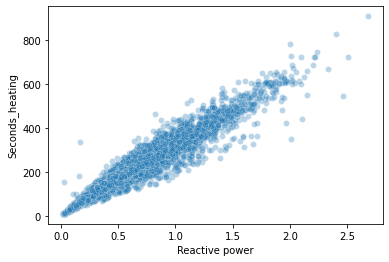

In [7]:
data_arc = data_arc.drop(data_arc[data_arc['Reactive power']== min(data_arc['Reactive power'])].index.tolist(), 0)
print("Correlation heating time-reactive power:", data_arc['Seconds_heating'].corr(data_arc['Reactive power']))
sns.scatterplot(data=data_arc, x='Reactive power', y="Seconds_heating", alpha=0.3) 

### Observation 2 
There is an expectedly high correlation between heating time and powers: 97%. The correlation with reactive power is initially low due to the negative overshoot that has been removed.

Let's analyze the temperature indicators: all measurements, separately the first measurement and the last one.

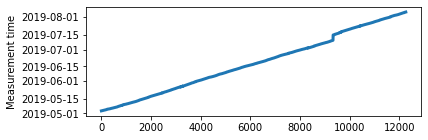

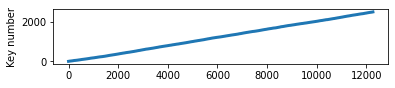

In [8]:
plt.figure(figsize=(6,2))
plt.ylabel('Measurement time')
plt.plot(data_temp['Measurement time'], linewidth=3)
plt.show()

plt.figure(figsize=(6,1))
plt.ylabel('Key number')
plt.plot(data_temp['key'], linewidth=3)
plt.show()

### Observation 3
The time of measurements and the batch number are in order, the data doesn't need to be sorted by time -  we can work with the current table.

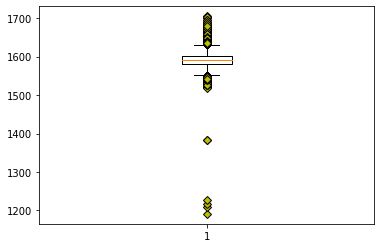

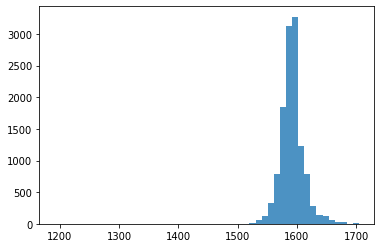

count    12265.000000
mean      1591.998859
std         20.834479
min       1191.000000
25%       1581.000000
50%       1591.000000
75%       1601.000000
max       1705.000000
Name: Temperature, dtype: float64

In [9]:
plt.boxplot(data_temp['Temperature'], flierprops=dict(markerfacecolor='y', marker='D'))
plt.show()

plt.hist(data_temp['Temperature'], bins=50, alpha=0.8)
plt.show()

data_temp['Temperature'].describe()

### Observation 4 
The temperature values are grouped quite tightly: from the 25% quantile to the maximum value of about 120 degrees.
In this case, the minimum value differs by 300 degrees from the value of the 25% quantile. The average temperature of steel during melting starts from 1350 degrees. Most likely, a lower temperature indicates a strong outlier in the value that should be removed (remove by the keys - as we for the temperature measurement we will assume a temperature per key).

In [10]:
data_temp.sort_values(by='Temperature').head(5)

,key,Measurement time,Temperature
4350,867,2019-06-04 14:21:00,1191.0
5978,1214,2019-06-16 05:32:00,1208.0
7958,1619,2019-06-30 11:03:54,1218.0
10127,2052,2019-07-21 14:51:40,1227.0
8914,1818,2019-07-07 00:31:40,1383.0


In [11]:
#delete outliers from the data_temp
keys_to_drop = [867, 1214, 1619, 2052]

data_temp = data_temp.query('key != @keys_to_drop') 

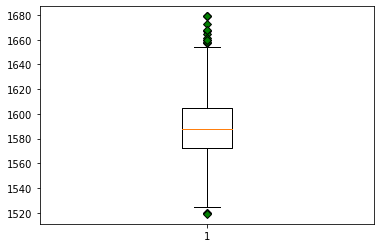

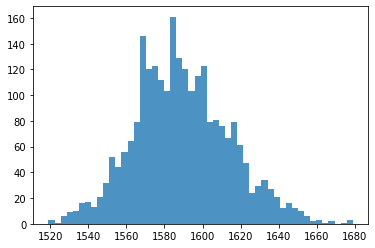

,Temperature
count,2471.000000
mean,1589.012950
std,25.004369
min,1519.000000
25%,1572.000000
50%,1588.000000
75%,1605.000000
max,1679.000000


In [12]:
temp_first = data_temp.pivot_table(index='key', values='Temperature', aggfunc = 'first')
plt.boxplot(temp_first, flierprops=dict(markerfacecolor='g', marker='D'))
plt.show()


plt.hist(temp_first, bins=50, alpha=0.8)
plt.show()

temp_first.describe()

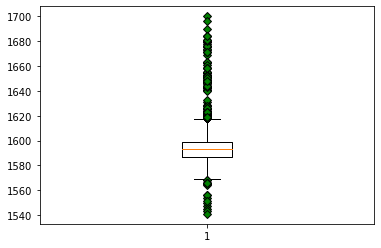

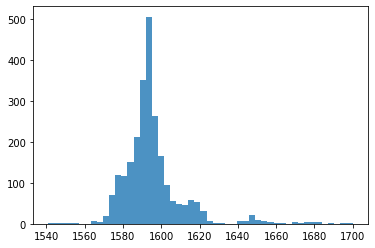

,Temperature
count,2471.000000
mean,1595.339943
std,16.035215
min,1541.000000
25%,1587.000000
50%,1593.000000
75%,1599.000000
max,1700.000000


In [13]:
temp_last = data_temp.pivot_table(index='key', values='Temperature', aggfunc = 'last')
plt.boxplot(temp_last, flierprops=dict(markerfacecolor='g', marker='D'))
plt.show()

plt.hist(temp_last, bins=50, alpha=0.8)
plt.show()

temp_last.describe()

### Observation 5

If we remove the value of outliers, the temperatures vary within 180 degrees: from 1518 to 1700 degrees.

At the same time, the final temperature is about 20 degrees higher than the initial one.
The initial temperature distribution has several peaks - 1570, 1585 and 1600 degrees. This may mean that the steel is initially heated to a certain temperature before the composition is analyzed and decisions about additives are made.

The distribution of final temperature values tends to normal.

The boxplot shows that the outliers are slightly skewed towards higher temperatures. It is proposed not to remove higher temperature spikes, as it is important for the customer to understand how energy can be saved, and a higher temperature can mean more consumption.

<AxesSubplot:ylabel='Frequency'>

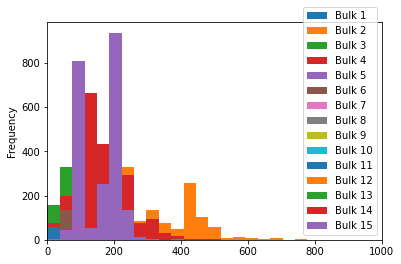

In [14]:
data_bulk.drop('key',1).plot(kind='hist', bins=50, xlim = (0,1000))

### Observation 6 
The largest amount of materials is submitted at the 15th stage. The volume values of bulk materials vary in the region of 150-220 volume units for stage 14-15, at stage 5, on average, fewer materials are supplied - 100. At stage 12, the volume of materials increases to 420 volume units. The distribution by stages tends to normal.

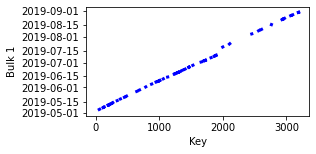

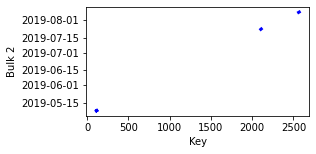

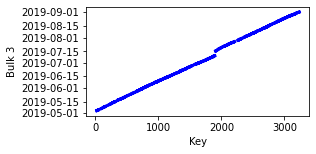

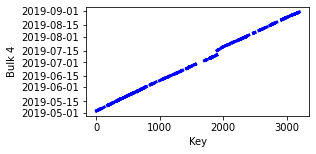

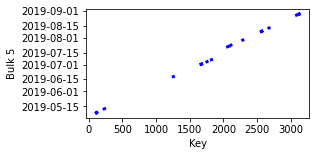

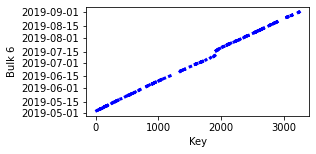

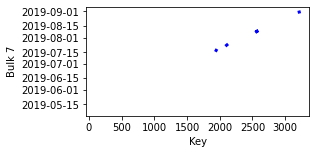

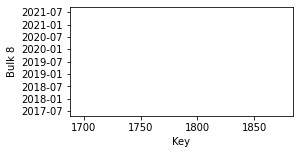

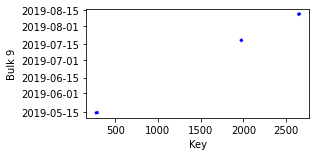

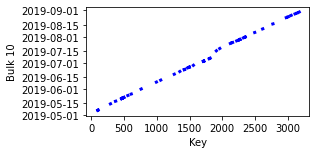

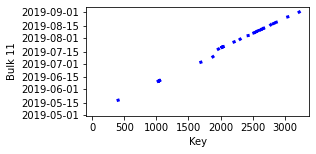

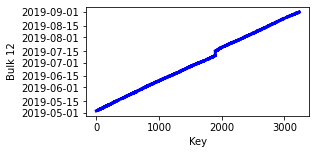

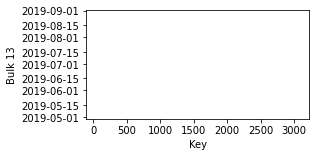

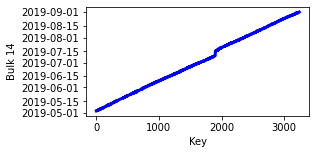

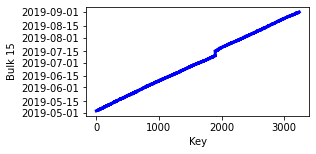

In [15]:
for i in data_bulk_time_temp.columns:
    plt.figure(figsize=(4,2))
    plt.xlabel('Key')
    plt.ylabel(i)
    plt.plot(data_bulk_time_temp[i], color = 'blue', linewidth=3)
    plt.show()

### Observation 7
The data on the time of adding bulk materials form a line graph: the date increases with the key (batch number), which indicates that the data is adequately represented. A small time lag is observed around the batch of 1900 - this may be due to the bucket stop for some technical work. Or that part of the data will be used later by the client for an independent model test.

<AxesSubplot:ylabel='Frequency'>

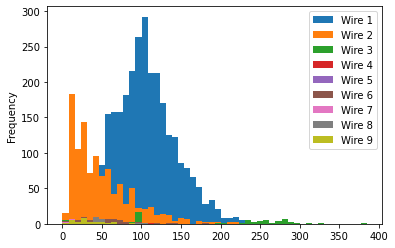

In [16]:
data_wire.drop('key',1).plot(kind='hist', bins=50)

### Observation 8
Adding of wire materials is carried out mainly in stages 1 and 2. Values at step 1 are larger - normally distributed around an average of 110 volume units. At the same time, at the second stage, the amount of material is on average lower - from 25 to 75 units of volume on average, there is a skew to the right (on average, more material is fed).

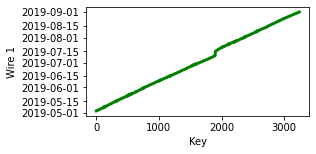

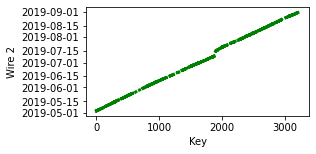

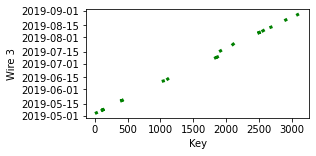

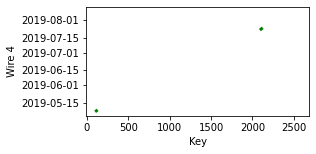

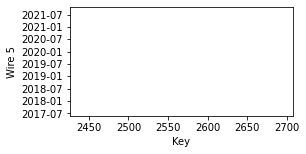

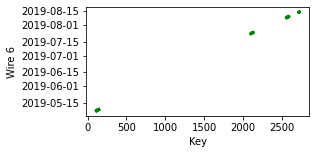

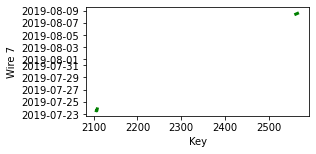

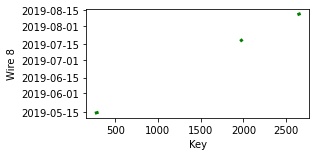

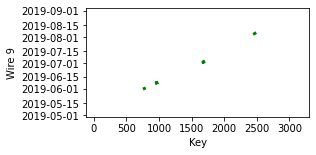

In [17]:
for i in data_wire_time_temp.columns:
    plt.figure(figsize=(4,2))
    plt.xlabel('Key')
    plt.ylabel(i)
    plt.plot(data_wire_time_temp[i], color = 'green', linewidth=3)
    plt.show()

### Observation 9
As in the case of bulk materials, the wire addition time data form a line graph: the date increases with the batch number, which indicates the adequacy of the data. Also, a small lag is observed in the area of the 1900 keys.

<AxesSubplot:ylabel='Frequency'>

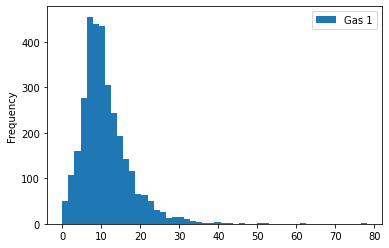

In [18]:
data_gas.drop('key',1).plot(kind='hist', bins=50)

### Observation 10
The distribution of gas supply tends to be normal, the average is around 7-12 units.

Before merging the data into the final table to check the correlation of features, the batches with no gas, addition of bulk materials, addition of wire materials at any of the iterations will be deleted.

In [19]:
##build a summary table for analytics and check gaps
data_bulk['total'] = data_bulk.sum(axis=1)-data_bulk['key']
data_wire['total'] = data_wire.sum(axis=1)-data_wire['key']
pivot_arc_0 = data_arc.pivot_table(index='key', values=['Active power', 'Reactive power', 'Seconds_heating'], aggfunc = 'mean')

total_table = temp_last.merge(temp_first,on='key', how='left', 
                              suffixes=('_last_temp', '_first_temp')).merge(pivot_arc_0,on='key', 
                                how='left').merge(data_gas,on='key', how='left').merge(data_bulk[['key','total']], on='key', 
                                how='left').merge(data_wire[['key','total']], on='key', 
                                how='left', suffixes = ('_bulk', '_wire'))

for column in total_table.columns:
    display(total_table[total_table[column].isna()].head())

,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire
190,193,1595.0,1593.0,0.683003,0.504593,173.333333,NaN,714.0,122.129272
255,259,1590.0,1577.0,0.668072,0.557624,179.250000,NaN,556.0,55.080479


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire
48,51,1690.0,1619.0,1.421179,0.956932,323.25,9.236758,NaN,NaN
49,52,1669.0,1617.0,0.842136,0.590314,236.00,14.119615,NaN,NaN
50,53,1671.0,1642.0,1.175670,0.854631,262.00,7.090307,NaN,NaN
51,54,1663.0,1630.0,0.976084,0.657485,219.25,5.547380,NaN,NaN
52,55,1654.0,1615.0,1.149717,0.776490,255.25,8.915683,NaN,NaN


,key,Temperature_last_temp,Temperature_first_temp,Active power,Reactive power,Seconds_heating,Gas 1,total_bulk,total_wire
48,51,1690.0,1619.0,1.421179,0.956932,323.25,9.236758,NaN,NaN
49,52,1669.0,1617.0,0.842136,0.590314,236.00,14.119615,NaN,NaN
50,53,1671.0,1642.0,1.175670,0.854631,262.00,7.090307,NaN,NaN
51,54,1663.0,1630.0,0.976084,0.657485,219.25,5.547380,NaN,NaN
52,55,1654.0,1615.0,1.149717,0.776490,255.25,8.915683,NaN,NaN


In [20]:
to_delete_bulk_keys = (total_table[total_table['total_bulk'].isna()]['key']).tolist()
to_delete_wire_keys = (total_table[total_table['total_wire'].isna()]['key']).tolist()
to_delete_gas_keys = (total_table[total_table['Gas 1'].isna()]['key']).tolist()

In [21]:
temp_last = temp_last.query('key != @to_delete_bulk_keys')
temp_last = temp_last.query('key != @to_delete_wire_keys')
temp_last = temp_last.query('key != @to_delete_gas_keys')
temp_last.shape

(2325, 1)

In [22]:
total_table = temp_last.merge(temp_first,on='key', how='left', 
                              suffixes=('_last_temp', '_first_temp')).merge(pivot_arc_0,on='key', 
                                how='left').merge(data_gas,on='key', how='left').merge(data_bulk[['key','total']], on='key', 
                                how='left').merge(data_wire[['key','total']], on='key', 
                                how='left', suffixes = ('_bulk', '_wire'))
total_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2325 non-null   int64  
 1   Temperature_last_temp   2325 non-null   float64
 2   Temperature_first_temp  2325 non-null   float64
 3   Active power            2325 non-null   float64
 4   Reactive power          2325 non-null   float64
 5   Seconds_heating         2325 non-null   float64
 6   Gas 1                   2325 non-null   float64
 7   total_bulk              2325 non-null   float64
 8   total_wire              2325 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 181.6 KB


<AxesSubplot:>

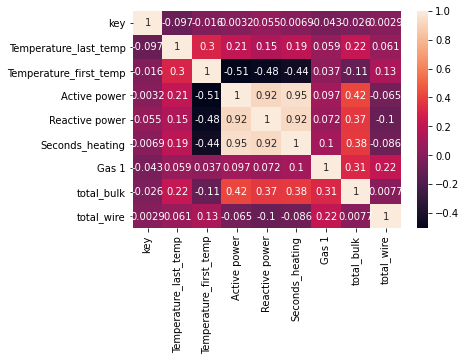

In [23]:
sns.heatmap(total_table.corr(), annot = True)

<AxesSubplot:xlabel='Temperature_last_temp', ylabel='total_bulk'>

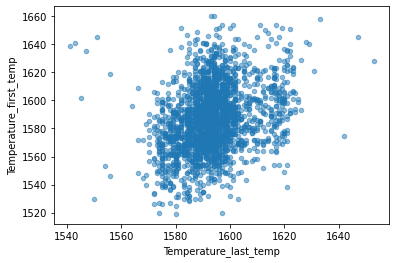

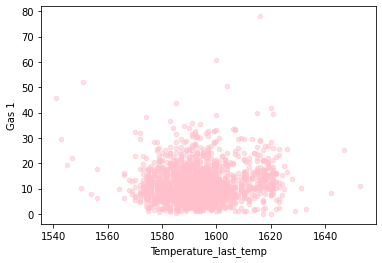

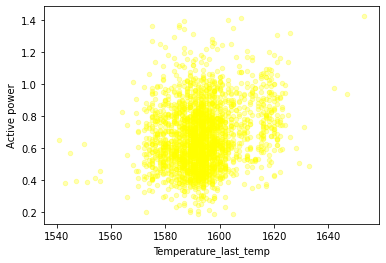

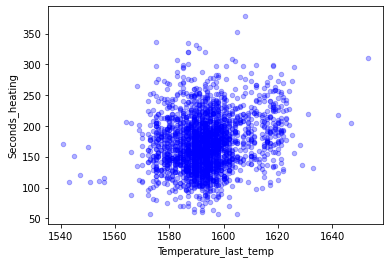

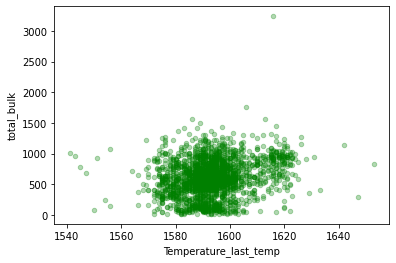

In [24]:
total_table.plot(kind='scatter', x='Temperature_last_temp', y='Temperature_first_temp', alpha=0.5) 
total_table.plot(kind='scatter', x='Temperature_last_temp', y='Gas 1', alpha=0.5, color='pink') 
total_table.plot(kind='scatter', x='Temperature_last_temp', y='Active power', alpha=0.3, color='yellow') 
total_table.plot(kind='scatter', x='Temperature_last_temp', y='Seconds_heating', alpha=0.3, color='blue')
total_table.plot(kind='scatter', x='Temperature_last_temp', y='total_bulk', alpha=0.3, color='green')

### 1.1. Conclusions

The final temperature data varies within 160 degrees: from 1540 to 1700. The final temperature readings are about 20 degrees higher than the initial ones. The initial temperature distribution has several peaks, which may mean that the steel is initially heated to a certain temperature before the composition is analyzed. The distribution of final temperature values tends to normal.

The steel temperature at the last stage and the temperature at the first measurement have a slight linear relationship - the indicators correlate by **30%**. At the same time, the heating time has a strong influence on the powers. The analysis also showed that the temperature does not necessarily increase with the addition of wire and bulk materials and gas purge. At the same time, materials are not added at every stage, on average additions have a normal distribution.

The analysis of the time of bulk and wire materials additions showed that the data provided are adequate.

At the next stage, feature engineering will be carried out.

<a id='second'></a>
## 2. Feature engineering

1) **To take into account the heating time and power in one feature**, the work (A) will be calculated using the formula: <br/>
`A = St`: the power is multiplied by the time during which this work has been done, where S is the total power, calculated by the formula: <br/>
`S = (P^2 + Q^2)^(1/2) ` is the root sum of the squares of active (P) and reactive (Q) powers.<br/>
For each batch, take the total work.

2) At the same time, we will keep the feature Heating time and power as a ratio **P/Q**

3) In addition, let's add the feature **number of iterations** (number of temperature measurements for each batch).

4) We will also remove the Bulk 8 and Wire 5 signs - there is only 1 measurement from these features, which is not informative.

Next, we will build a feature correlation table to find out if further changes to the features are necessary.

In [25]:
#Feature engineering
data_arc['Work'] = data_arc['Seconds_heating'] * ((data_arc['Active power']**2+ data_arc['Reactive power']**2)**(1/2))
data_arc['Power_ratio'] = data_arc['Active power']/data_arc['Reactive power']

pivot_arc = data_arc.pivot_table(index='key', values=['Work', 'Seconds_heating'], aggfunc = 'sum')
pivot_arc_1 = data_arc.pivot_table(index='key', values='Power_ratio', aggfunc = 'mean')
iterations = data_temp.pivot_table(index='key', values='Temperature', aggfunc = 'count')

total_table = temp_last.merge(temp_first,on='key', how='left',  suffixes=('_last_temp', '_first_temp'))

total_table = total_table.merge(pivot_arc,on='key', how='left')
total_table = total_table.merge(pivot_arc_1,on='key', how='left')
total_table = total_table.merge(iterations,on='key', how='left')

total_table = total_table.merge(data_gas,on='key', how='left')
total_table = total_table.merge(data_bulk.drop(['total'], axis=1), on='key', how='left')
total_table = total_table.merge(data_wire.drop(['total'], axis=1), on='key', how='left', suffixes = ('_bulk', '_wire'))
total_table = total_table.fillna(0)
total_table.info()
total_table.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   key                     2325 non-null   int64  
 1   Temperature_last_temp   2325 non-null   float64
 2   Temperature_first_temp  2325 non-null   float64
 3   Seconds_heating         2325 non-null   float64
 4   Work                    2325 non-null   float64
 5   Power_ratio             2325 non-null   float64
 6   Temperature             2325 non-null   int64  
 7   Gas 1                   2325 non-null   float64
 8   Bulk 1                  2325 non-null   float64
 9   Bulk 2                  2325 non-null   float64
 10  Bulk 3                  2325 non-null   float64
 11  Bulk 4                  2325 non-null   float64
 12  Bulk 5                  2325 non-null   float64
 13  Bulk 6                  2325 non-null   float64
 14  Bulk 7                  2325 non-null   

,key,Temperature_last_temp,Temperature_first_temp,Seconds_heating,Work,Power_ratio,Temperature,Gas 1,Bulk 1,Bulk 2,...,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1613.0,1571.0,1098.0,1442.377754,1.538898,5,29.749986,0.0,0.0,...,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1602.0,1581.0,811.0,881.233565,1.551834,6,12.555561,0.0,0.0,...,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1599.0,1596.0,655.0,525.066777,1.583120,5,28.554793,0.0,0.0,...,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1625.0,1601.0,741.0,796.911309,1.563487,3,18.841219,0.0,0.0,...,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1602.0,1576.0,869.0,1199.137958,1.480428,2,5.413692,0.0,0.0,...,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

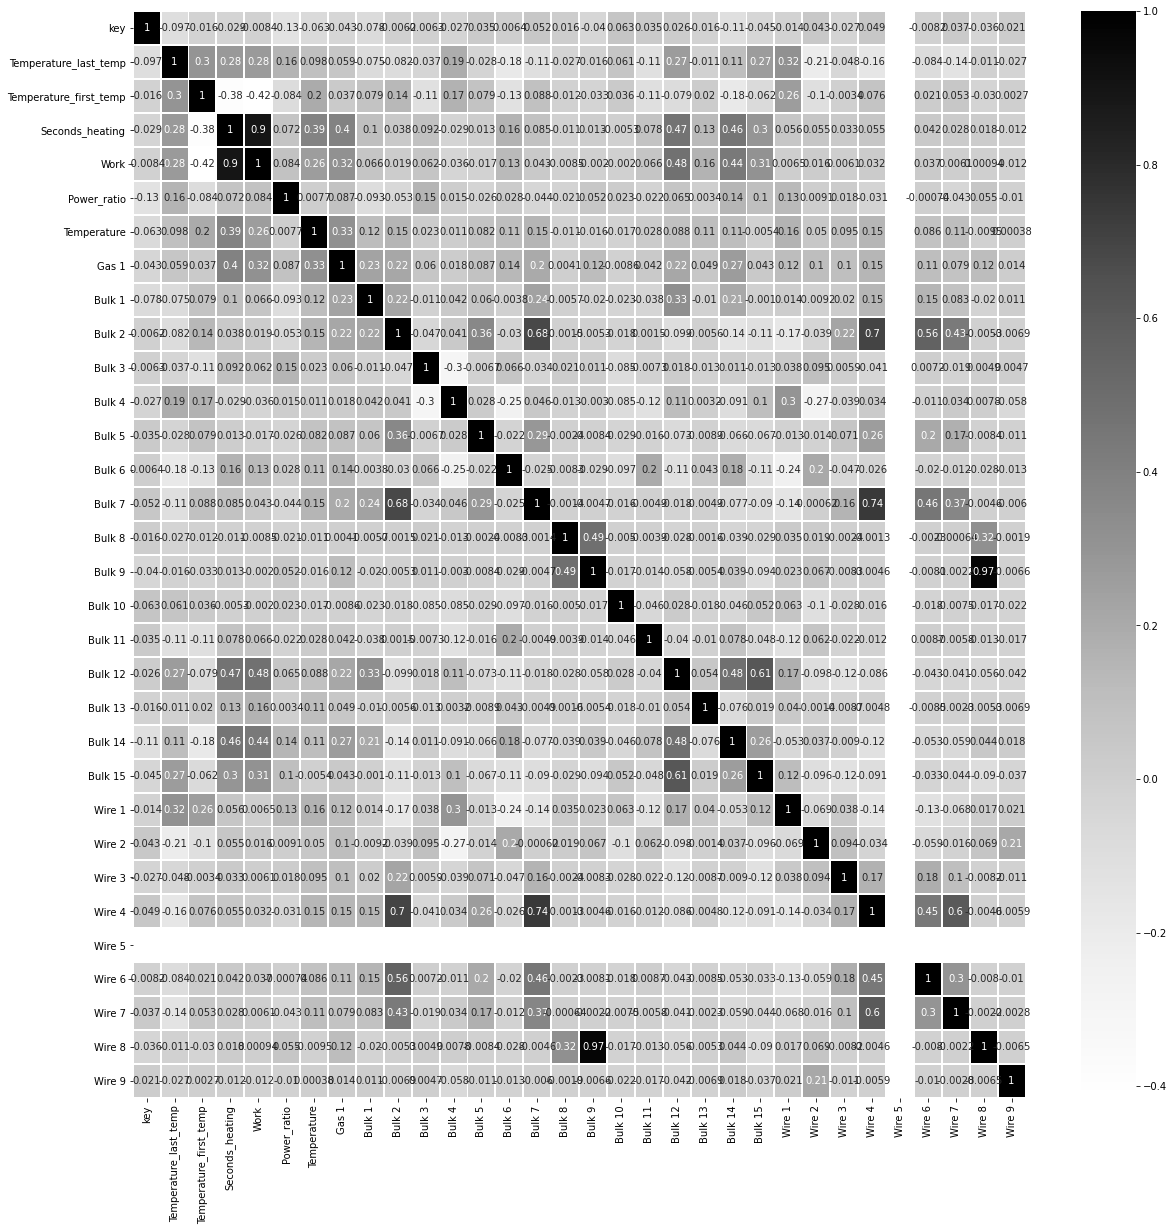

In [26]:
plt.figure(figsize=(20,20))
sns.heatmap(total_table.corr(), annot = True, cmap='Greys', linewidths=1 )

### 2.1. Conclusions
The feature correlation is not high, with the exception of Bulk 9 and Wire 8. We remove the Wire 8 feature from training. The next step is machine learning.

<a id='third'></a>
## 3. Machine learning

In [27]:
rand_state = 20111995 #random random state

In [28]:
x = total_table.drop(['key', 'Temperature_last_temp', 'Wire 8', 'Bulk 8','Wire 5'], 1)
y = total_table['Temperature_last_temp']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=rand_state)

print("Size - train sample", x_train.shape, y_train.shape) 
print("Size - test sample", x_test.shape, y_test.shape) 

Size - train sample (1627, 27) (1627,)
Size - test sample (698, 27) (698,)


The data has been split to 2 samples: train and test, as it is planned to use cross-validation. The ratio is 70/30.

In [29]:
x_train_linear = x_train
scaler = StandardScaler()
scaler.fit(x_train_linear[x_train.columns])
x_train_linear = scaler.transform(x_train_linear[x_train.columns])

model_linear = LinearRegression()

print('Mean MAE train linear:')
(cross_val_score(model_linear, x_train_linear, y_train, cv=5, scoring = 'neg_mean_absolute_error').mean())*(-1)

Mean MAE train linear:


6.1460060004970725

Scaling of features has been used for the linear model.

In [30]:
model_tree = DecisionTreeRegressor(random_state = rand_state, max_depth=8)

print('Mean MAE train tree:')
(cross_val_score(model_tree, x_train, y_train, cv=5, scoring = 'neg_mean_absolute_error').mean())*(-1)

Mean MAE train tree:


7.417243907419097

In [31]:
estimator_forest = RandomForestRegressor(random_state = rand_state)
param_grid_forest = {
    'criterion':['mae'],
    "n_estimators": [50, 70, 80],
    "max_depth": [3, 7, 10]}

grid = GridSearchCV(estimator_forest, param_grid_forest, scoring='neg_mean_absolute_error', cv=5)
grid.fit(x_train, y_train)

print(grid.best_score_ , grid.best_params_)

-6.157382314771115 {'criterion': 'mae', 'max_depth': 10, 'n_estimators': 80}


In [32]:
estimator_cat = CatBoostRegressor(random_state = rand_state)

param_grid_cat = {'learning_rate': [0.03, 0.1],
                  'depth': [6, 10],
                  'iterations': [100, 200],
                 'l2_leaf_reg': [1, 3]}

grid = GridSearchCV(estimator_cat, param_grid_cat, scoring='neg_mean_absolute_error', cv=5)
grid.fit(x_train, y_train)

print(grid.best_score_ , grid.best_params_)

0:	learn: 10.9769582	total: 50.5ms	remaining: 5s
1:	learn: 10.8883815	total: 58.2ms	remaining: 2.85s
2:	learn: 10.8006428	total: 61.3ms	remaining: 1.98s
3:	learn: 10.7109696	total: 64.2ms	remaining: 1.54s
4:	learn: 10.6259832	total: 66.9ms	remaining: 1.27s
5:	learn: 10.5448992	total: 69.6ms	remaining: 1.09s
6:	learn: 10.4633590	total: 72.5ms	remaining: 963ms
7:	learn: 10.3982240	total: 75.2ms	remaining: 865ms
8:	learn: 10.3388857	total: 78ms	remaining: 789ms
9:	learn: 10.2675182	total: 80.7ms	remaining: 726ms
10:	learn: 10.1858623	total: 83.4ms	remaining: 675ms
11:	learn: 10.1202080	total: 86ms	remaining: 631ms
12:	learn: 10.0389019	total: 88.6ms	remaining: 593ms
13:	learn: 9.9729351	total: 91.3ms	remaining: 561ms
14:	learn: 9.9069031	total: 94ms	remaining: 533ms
15:	learn: 9.8490127	total: 96.7ms	remaining: 508ms
16:	learn: 9.7913856	total: 99.3ms	remaining: 485ms
17:	learn: 9.7376840	total: 102ms	remaining: 465ms
18:	learn: 9.6773660	total: 105ms	remaining: 447ms
19:	learn: 9.6202421

In [33]:
model_lgb = lgb.LGBMRegressor(max_depth = 3, learning_rate = 0.1, random_state = rand_state)

print('Mean MAE train lgb:')
(cross_val_score(model_lgb, x_train, y_train, cv=5, scoring = 'neg_mean_absolute_error').mean())*(-1)

Mean MAE train lgb:


5.962509319693337

### 3.1. Conclusions
The best MAE metric on training data using cross-validation was achieved on the **CatBoost Regressor model**.
On the next step, the model will be validated on test data.

<a id='fourth'></a>
## 4. Test

Let's check the CatBoostRegressor model on the test sample.

In [34]:
model_cat = CatBoostRegressor(random_state = rand_state, learning_rate = 0.1, depth = 6, iterations = 200, verbose = 50, l2_leaf_reg=3)

model_cat.fit(x_train, y_train)
predict_test_cat = model_cat.predict(x_test)
print("MAE test best model", mean_absolute_error(y_test, predict_test_cat))

0:	learn: 10.7865276	total: 3.48ms	remaining: 693ms
50:	learn: 7.2314340	total: 146ms	remaining: 427ms
100:	learn: 6.2112023	total: 287ms	remaining: 281ms
150:	learn: 5.4668047	total: 431ms	remaining: 140ms
199:	learn: 4.9147220	total: 578ms	remaining: 0us
MAE test best model 5.985669685609115


Let's also check the success of the best model built in comparison with the dummy model (by median).

In [35]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(x_train, y_train)
predict_test_dummy = dummy_regr.predict(x_test)
print("MAE dummy-model:", mean_absolute_error(y_test, predict_test_dummy))

MAE dummy-model: 8.299426934097422


<AxesSubplot:>

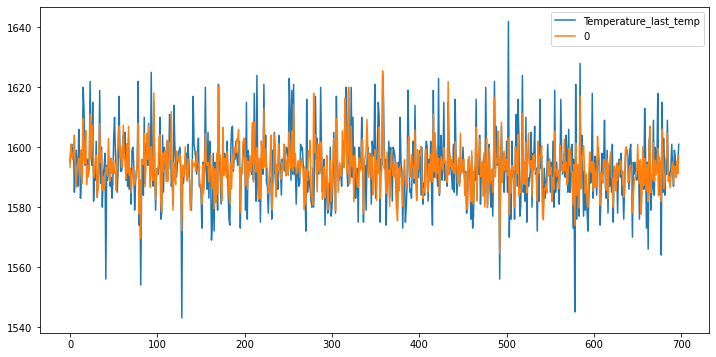

In [36]:
final_data = pd.concat([y_test.reset_index(drop=True), pd.Series(predict_test_cat)], axis=1)
final_data.plot(figsize=(12,6))

### 4.1. Conclusions
The MAE metric on the test sample is **5.985**, which falls within the range of acceptable metrics.

The metric means that, on average, the model is off by almost 6 degrees in its temperature predictions. Also, the model was tested for adequacy - the constant model (median) showed the worse result.

It can be seen from the graph that the model has difficulty predicting **outliers**, especially at lower temperatures, which makes sense given that there are more higher values in the temperature data. It can also be seen from the graph that the model predictions are highly correlated with the target data.

<a id='fifth'></a>
## 5. Summary

Thus, during the project, the model that predicts the final melting temperature of steel after several iterations was built.

The median melting point of steel is 1.593 degrees. The final metric on the test data was below 6 - the model is on average less than 6 degrees wrong in the prediction.

The model will work a little worse with low temperatures, because such temperatures are less common.

To build the model, the initial data was taken with some transformations: 

1) work was calculated in the electrode data <br/>
2) the ratio of active power to reactive power was added <br/>
3) the number of iterations was also calculated <br/>
4) some stages of the addition of bulk and wire materials were removed, where there were few indicators.